# Visualizing MNIST database

This example creates a visualization of the MNIST images (hand written digits) using `MLDatasets.jl` to retrieve it.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="MLDatasets"),
    PackageSpec(name="Plots"),
    PackageSpec(name="HypertextLiteral"),
])

using SimilaritySearch, SimSearchManifoldLearning, Plots, LinearAlgebra, MLDatasets, HypertextLiteral
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/MNIST`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/MNIST/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/MNIST/Manifest.toml`


# Functions to parse and vectorize texts

In [2]:
function create_index()
    data = MNIST(split=:train)
    T, y = data.features, data.targets
    n = size(T, 3)
    db = MatrixDatabase(Matrix{Float32}(reshape(T, (28*28, n))))
	dist = SqL2Distance()
    index = SearchGraph(; dist, db, verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
	index, y
end

function create_umap_embeddings(index; force=true, k=15, n_epochs=50, neg_sample_rate=3, layout=RandomLayout(), tol=1e-3)
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data's size
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    (e2=U2.embedding, e3=U3.embedding)
end


create_umap_embeddings (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [3]:
@time index, y = create_index();

  5.266572 seconds (9.34 M allocations: 894.903 MiB, 2.44% gc time, 62.06% compilation time)


In [4]:
function search_and_display(index, q, res)
	res = reuse!(res)
    @time search(index, q, res)
	qinverted = 1 .- reshape(q, (28, 28))' # distinguishability
	h = hcat(qinverted, [reshape(index[id_], (28, 28))' for id_ in idview(res)]...)
	
    Gray.(h)
end


search_and_display (generic function with 1 method)

In [5]:

res = KnnResult(10)
for i in 1:7
    for qid in rand(1:length(index))
        display(@htl "<h2> searching for id $qid </h2>")
        display(search_and_display(index, index[qid], res))
    end
end
    


<h2> searching for id 16293 </h2>

  0.000129 seconds (6 allocations: 512 bytes)


<h2> searching for id 25916 </h2>

  0.000198 seconds (6 allocations: 512 bytes)


<h2> searching for id 55395 </h2>

  0.000203 seconds (6 allocations: 512 bytes)


<h2> searching for id 54593 </h2>

  0.000213 seconds (6 allocations: 512 bytes)


<h2> searching for id 13323 </h2>

  0.000112 seconds (6 allocations: 512 bytes)


<h2> searching for id 18892 </h2>

  0.000105 seconds (6 allocations: 512 bytes)


<h2> searching for id 55335 </h2>

  0.000162 seconds (6 allocations: 512 bytes)


# Visualization

## Functions to create low dimensional projections

In [6]:
function create_umap_embeddings(index; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-4, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U2.embedding
end

function plot_umap(e2, labels)
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=labels, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    L = rand(1:length(X), 100)
	annotate!(X[L], Y[L], text.(string.(labels[L]), 8, 0.3, :black))
    display(plot!(title="colors are related to label")) 
end

plot_umap (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [7]:
@time e2 = create_umap_embeddings(index);

  0.438242 seconds (362.66 k allocations: 38.132 MiB)
105.100794 seconds (29.52 M allocations: 6.352 GiB, 1.03% gc time, 11.74% compilation time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.321480541
- embedding init: 92.408097244
- embedding opt: 1.662647237



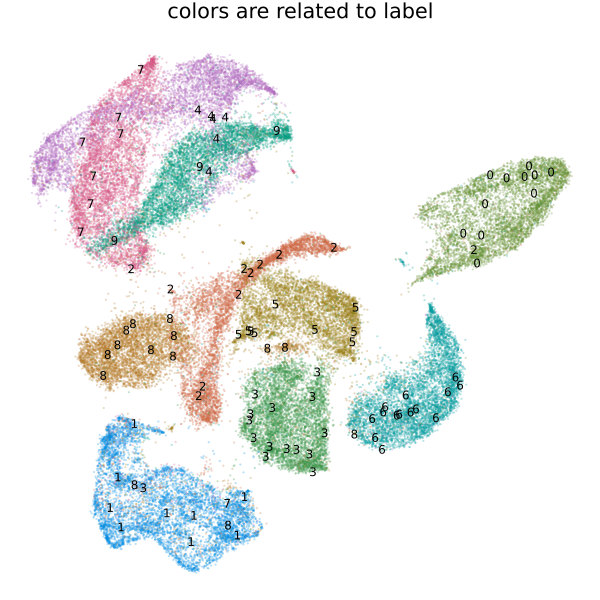

In [8]:
plot_umap(e2, y)

# Final notes

This example shows how to index and visualize the MNIST dataset using UMAP low dimensional projections. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [9]:
Pkg.status()

      Status `~/Research/SimilaritySearchDemos/MNIST/Project.toml`
  [ac1192a8] HypertextLiteral v0.9.4
  [eb30cadb] MLDatasets v0.7.2
  [91a5bcdd] Plots v1.30.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.4
  [053f045d] SimilaritySearch v0.9.2
